In [1]:
import random
import itertools

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection

In [2]:
def createLSTMLayers(n_layers, n_cells, dropout):
    cell_list = []
    
    for layer in range(n_layers):
        cell = tf.contrib.rnn.LayerNormBasicLSTMCell(n_cells, activation=tf.nn.relu, layer_norm=False)
        
        cell_list.append(cell)
        
    return cell_list

In [3]:
def padSeq(seqs, pad_length, right_pad=True):
    
    '''
    padSeq
    
    Pad sequences to be equal length.
    
    seqs: sequences to be padded
    pad_length: length to pad sequences
    left_pad: Pad at the end of the sequences, or reverse pad from front
    '''
    
    padded_seqs = np.zeros((len(seqs), pad_length))
    
    for idx_row, row in enumerate(seqs):
        for idx_col, col in enumerate(row):
            if right_pad:
                padded_seqs[idx_row, idx_col] = seqs[idx_row][idx_col]
            else:
                padded_seqs[idx_row, pad_length-idx_col-1] = seqs[idx_row][len(row)-idx_col-1]
    return padded_seqs

In [194]:
tf.reset_default_graph()

#Network parameters
encoder_layers = 1
encoder_cells = 6
encoder_dropout = 1

decoder_layers = 1
decoder_cells = 6
decoder_dropout = 1

seq_length = 5
n_features = 1

embedding_dimensions = 13
vocabulary_size = 10
latent_dimensions = 2

#Training Parameters
lr = 0.001
batch_size = 128

In [195]:
inputs = tf.placeholder(name='input', shape=[None, seq_length], dtype=tf.int32)

In [216]:
input_lengths = tf.placeholder(name='input_lengths', shape=[None], dtype=tf.int32)

In [196]:
embedding_matrix = tf.get_variable('embeddings', [vocabulary_size, embedding_dimensions])

In [197]:
embedding_inputs = tf.nn.embedding_lookup(embedding_matrix, inputs)

In [198]:
#encoder
with tf.variable_scope('encoder', reuse=False):
    
    encoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    encoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    
    (encoder_fw_outputs, encoder_bw_outputs), encoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        encoder_cell_fw,
                                        encoder_cell_bw, 
                                        inputs=embedding_inputs,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    encoder_final_state = tf.concat([state_tuple[0].h for state_tuple in encoder_state_outputs], axis=1)

In [199]:
metrics = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())    

    results = sess.run([encoder_final_state], {inputs:[[2, 2, 2, 2, 2], [2, 2, 2, 2, 1]]})

In [200]:
latent_vector_in = tf.contrib.layers.fully_connected(encoder_final_state, latent_dimensions, 
                                                     activation_fn=tf.nn.relu,
                                                     normalizer_fn=tf.contrib.layers.batch_norm)

In [201]:
latent_vector_out = tf.contrib.layers.fully_connected(latent_vector_in, decoder_cells, 
                                                      activation_fn=tf.nn.relu,
                                                      normalizer_fn=tf.contrib.layers.batch_norm)

In [202]:
decoder_inputs = tf.zeros([tf.shape(inputs)[0], seq_length, n_features])

In [203]:
decoder_initial_state = tuple([tf.nn.rnn_cell.LSTMStateTuple(c=latent_vector_out, h=latent_vector_out) for i in 
                              range(decoder_layers)])

In [204]:
#decoder

with tf.variable_scope('decoder', reuse=False):
    
    decoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    decoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    
    (decoder_fw_outputs, decoder_bw_outputs), decoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        decoder_cell_fw,
                                        decoder_cell_bw, 
                                        inputs=decoder_inputs,
                                        initial_state_fw=decoder_initial_state,
                                        initial_state_bw=decoder_initial_state,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    decoder_outputs = tf.reduce_sum([decoder_fw_outputs, decoder_bw_outputs], axis=0)

In [206]:
#I think what is confusing you here is that the input has to one hot encoded if they categorical!

In [207]:
output_layer = tf.contrib.layers.fully_connected(decoder_outputs, vocabulary_size, activation_fn=tf.nn.relu)

In [208]:
output_probs = tf.contrib.layers.softmax(output_layer)

In [209]:
output_pred = tf.argmax(output_layer, axis=2)

In [210]:
output_probs, output_pred, inputs

(<tf.Tensor 'softmax/Reshape_1:0' shape=(?, 5, 10) dtype=float32>,
 <tf.Tensor 'ArgMax:0' shape=(?, 5) dtype=int64>,
 <tf.Tensor 'input:0' shape=(?, 5) dtype=int32>)

In [ ]:
metrics = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())    
    
    print ('Begin training')

    results = sess.run([loss, inputs, output_layer, prediction], {inputs:[[2, 2, 2, 2, 2]]})

In [225]:
masks = tf.sequence_mask(lengths=input_lengths, maxlen=seq_length, dtype=tf.float32, name='masks')

In [227]:
#Here the inputs can dense as opposed to one hot encoded
#loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=inputs, logits=output_layer)

#try using sequence loss instead

loss = tf.contrib.seq2seq.sequence_loss(logits=output_layer, targets=inputs, weights=masks)

In [104]:
#loss = tf.reduce_sum(tf.square(inputs-output_layer))

In [228]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [229]:
def generatePseudoSequences(seq_length, low, high, n_seqs, seed, variable_length=False):
    
    '''
    generatePseudoSequences
    
    seq_length: Length of sequence to generate
    low: lower bound of values
    high: upper bound of values
    n_seqs: number of sequences to generate
    variable_length: Create sequence of variable length    
    '''
    random.seed(seed)
    
    #Generate random sequences
    random_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        current_seq = [random.randint(low, high) for _ in range(current_length)]
        
        random_seqs.append(current_seq)
        
    #Generate repeating sequences    
    repeat_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value for _ in range(current_length)]
        
        repeat_seqs.append(current_seq)
        
    #Generate ascending sequences    
    ascend_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value+i for i in range(0, current_length, 1)]
        
        ascend_seqs.append(current_seq)
    
    #Generate descending sequences
    descend_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low+2, high)
        current_seq = [seq_value-i for i in range(0, current_length, 1)]
        
        descend_seqs.append(current_seq)
    
    #Generate skip sequences
    skip_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(2, seq_length)
        else: current_length = seq_length
        skip_value = random.randint(1, 5)
        seq_value = random.randint(low, high)
        seq_value = seq_value-skip_value
        current_seq = [seq_value+i*skip_value for i in range(0, current_length, 1)]
        
        skip_seqs.append(current_seq)
            
    #return np.concatenate([descend_seqs, ascend_seqs])
    #return skip_seqs
    return repeat_seqs

In [248]:
pseudo_seqs = generatePseudoSequences(seq_length, 1, 9, 50000, 0, variable_length=True)

In [249]:
pseudo_seqs_lengths = [len(i) for i in pseudo_seqs]

In [250]:
df_seqs = pd.DataFrame(padSeq(pseudo_seqs, seq_length))

In [252]:
seq_cols = df_seqs.columns.values

In [253]:
df_seqs['seq_length'] = pseudo_seqs_lengths

In [254]:
#df_seqs['label'] = df_seqs[seq_cols].apply(lambda x:'_'.join([str(i) for i in x]), axis=1)

In [255]:
#df_seqs['label'] = df_seqs[1]-df_seqs[0]

In [256]:
df_seqs['label'] = df_seqs[0].apply(str)

In [257]:
df_seqs = df_seqs.sample(frac=1)

In [258]:
df_seqs.head()

,0,1,2,3,4,seq_length,label
45052,6.0,6.0,6.0,6.0,6.0,5,6.0
11317,7.0,7.0,7.0,7.0,7.0,5,7.0
16620,7.0,7.0,0.0,0.0,0.0,2,7.0
43590,8.0,8.0,8.0,8.0,8.0,5,8.0
20159,2.0,2.0,2.0,2.0,2.0,5,2.0


In [259]:
df_train, df_test = model_selection.train_test_split(df_seqs, test_size=0.2)

In [260]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [261]:
#training

n_epochs = 50
n_batches = df_train.shape[0]//batch_size

In [263]:
metrics = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print ('Begin training')
    
    for c_epoch in range(n_epochs):
        df_train_current = df_train.sample(frac=1)
        
        for c_batch in range(n_batches): 
            batch = df_train_current[seq_cols][c_batch*batch_size:(c_batch+1)*batch_size].values
            batch_lengths = df_train_current['seq_length'][c_batch*batch_size:(c_batch+1)*batch_size].values

            #batch = batch.reshape(len(batch), seq_length, 1)
            results = sess.run([optimizer, loss, encoder_final_state, latent_vector_in, latent_vector_out, output_layer], 
                               {inputs:batch, input_lengths:batch_lengths})
            
            
            if c_batch%300==0:
                df_test_current = df_test.sample(n=batch_size)
                test_batch = df_test_current[seq_cols]
                test_batch_lengths = df_test_current['seq_length']
                #test_batch = test_batch.values.reshape(df_test_batch.shape[0], seq_length, 1)
                results_test = sess.run([loss, output_layer], 
                               {inputs:test_batch, input_lengths:test_batch_lengths})            
             
                
                print ('epoch:%d, batch:%d, batch loss:%.3g, test loss:%.3g, norm batch loss:%.3g, norm test loss:%.3g' % 
                       (c_epoch, c_batch, results[1], results_test[0], 
                        results[1]/batch_size, results_test[0]/batch_size))
                
                metrics.append([c_epoch, c_batch, results[1], results_test[0]])
    
        if c_epoch%10==0:
            
            latent_vectors_train = sess.run(latent_vector_in, 
                                      {inputs:df_train[seq_cols].values#.reshape(df_train.shape[0], seq_length, 1)
                                      })
            
            latent_vectors_test = sess.run(latent_vector_in, 
                                      {inputs:df_test[seq_cols].values#.reshape(df_test.shape[0], seq_length, 1)
                                      })
            
            total_output_test = sess.run(output_layer, 
                                         {inputs:df_test[seq_cols].values#.reshape(df_test.shape[0], seq_length, 1)
                                         })

Begin training
epoch:0, batch:0, batch loss:2.23, test loss:2.26, norm batch loss:0.0174, norm test loss:0.0177
epoch:0, batch:300, batch loss:1.06, test loss:1.08, norm batch loss:0.00828, norm test loss:0.00841
epoch:1, batch:0, batch loss:0.902, test loss:1.09, norm batch loss:0.00705, norm test loss:0.00852
epoch:1, batch:300, batch loss:0.469, test loss:0.396, norm batch loss:0.00366, norm test loss:0.00309
epoch:2, batch:0, batch loss:0.426, test loss:0.497, norm batch loss:0.00333, norm test loss:0.00388
epoch:2, batch:300, batch loss:0.217, test loss:0.226, norm batch loss:0.0017, norm test loss:0.00176
epoch:3, batch:0, batch loss:0.223, test loss:0.222, norm batch loss:0.00175, norm test loss:0.00173
epoch:3, batch:300, batch loss:0.212, test loss:0.233, norm batch loss:0.00166, norm test loss:0.00182
epoch:4, batch:0, batch loss:0.162, test loss:0.226, norm batch loss:0.00127, norm test loss:0.00177
epoch:4, batch:300, batch loss:0.175, test loss:0.188, norm batch loss:0.001

epoch:38, batch:300, batch loss:0.00209, test loss:0.000752, norm batch loss:1.63e-05, norm test loss:5.87e-06
epoch:39, batch:0, batch loss:0.000451, test loss:0.00128, norm batch loss:3.53e-06, norm test loss:1e-05
epoch:39, batch:300, batch loss:0.000415, test loss:0.000733, norm batch loss:3.24e-06, norm test loss:5.73e-06
epoch:40, batch:0, batch loss:0.00051, test loss:0.00061, norm batch loss:3.99e-06, norm test loss:4.77e-06
epoch:40, batch:300, batch loss:0.000443, test loss:0.00148, norm batch loss:3.46e-06, norm test loss:1.16e-05
epoch:41, batch:0, batch loss:0.0005, test loss:0.00326, norm batch loss:3.91e-06, norm test loss:2.55e-05
epoch:41, batch:300, batch loss:0.000798, test loss:0.00171, norm batch loss:6.23e-06, norm test loss:1.34e-05
epoch:42, batch:0, batch loss:0.00353, test loss:0.00101, norm batch loss:2.76e-05, norm test loss:7.91e-06
epoch:42, batch:300, batch loss:0.000908, test loss:0.000677, norm batch loss:7.09e-06, norm test loss:5.29e-06
epoch:43, batc

In [264]:
metrics = np.array(metrics)

In [265]:
plt.figure(figsize=(14, 10))
plt.semilogy([i for i in range(len(metrics[:,2]))], metrics[:,2], label='training loss')
plt.semilogy([i for i in range(len(metrics[:,3]))], metrics[:,3], label='test loss')
plt.legend(loc='best')
plt.show()

ValueError: setting an array element with a sequence.

In [268]:
df_vectors = pd.DataFrame(latent_vectors_train, columns=['x', 'y'])

In [127]:
#Join to training data
df_seqs_vectors = df_train.merge(df_vectors, left_index=True, right_index=True)

In [128]:
df_seqs_vectors['label_add'] = df_seqs_vectors['label'].apply(str) + df_seqs_vectors[0].apply(str)

In [129]:
df_seqs_vectors['label_add'].unique()

array(['3.06.0', '4.08.0', '4.07.0', '4.09.0', '2.04.0', '3.05.0',
       '2.07.0', '3.09.0', '5.09.0', '1.09.0', '4.010.0', '2.010.0',
       '5.06.0', '4.05.0', '1.04.0', '3.03.0', '1.010.0', '1.06.0',
       '3.04.0', '4.03.0', '5.08.0', '1.05.0', '2.03.0', '5.05.0',
       '5.04.0', '4.04.0', '2.05.0', '1.03.0', '2.08.0', '3.010.0',
       '5.010.0', '5.03.0', '2.09.0', '2.06.0', '1.08.0', '1.07.0',
       '3.08.0', '3.07.0', '4.06.0', '5.07.0'], dtype=object)

In [130]:
df_seqs_vectors[df_seqs_vectors[0]==3].head()

,0,1,2,3,4,label,x,y,label_add
18,3.0,6.0,9.0,12.0,0.0,3.0,0.723117,0.448238,3.03.0
27,3.0,7.0,11.0,0.0,0.0,4.0,0.358903,0.941783,4.03.0
35,3.0,5.0,7.0,0.0,0.0,2.0,0.486740,1.005442,2.03.0
41,3.0,4.0,5.0,6.0,7.0,1.0,1.049593,0.699132,1.03.0
43,3.0,7.0,11.0,0.0,0.0,4.0,0.358903,0.941783,4.03.0


In [131]:
label_col = 'label'

In [132]:
unique_seqs = df_seqs_vectors[label_col].unique()

In [133]:
palette = itertools.cycle(sns.color_palette(n_colors=len(unique_seqs)))

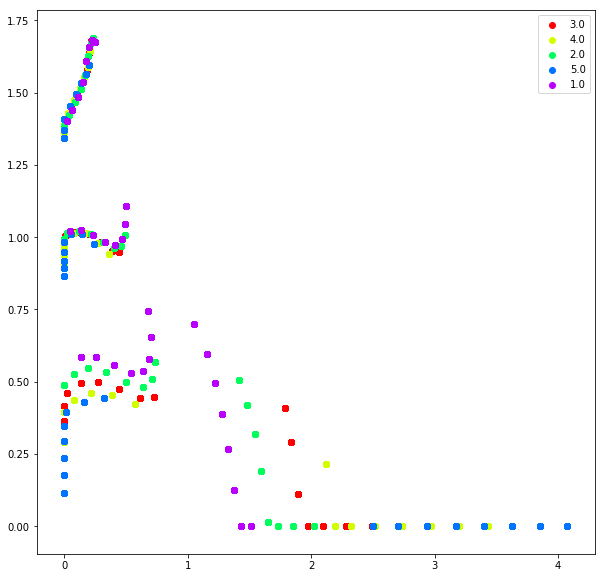

In [134]:
#Analysis

plt.figure(1, figsize=(10, 10))
cmap = plt.cm.get_cmap('hsv', len(unique_seqs)+1)
for idx_seq, seq in enumerate(unique_seqs):
    df_current = df_seqs_vectors[df_seqs_vectors[label_col]==seq]
    plt.scatter(df_current['x'].values, df_current['y'].values, color=cmap(idx_seq), label=seq)

plt.legend(loc='best')
plt.show()